In [31]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle
import latex

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, concatenate, SimpleRNN, Reshape, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

In [32]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 18

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

#matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [33]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [34]:
def train_nn(model, x, y, batch_size, loss, name, xval, pval):
    
    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit([x,y], x,
                     batch_size=batch_size,
                     epochs=500,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=([xval,pval],xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [35]:
good_data_file = 'PileupNewData_data.pickle'
bad_data_file = 'PileupNewData_bad.pickle'

subplot_size = [2,3]
fig_size = [20,20]

with open(good_data_file, 'rb') as handle:
    good_data = pickle.load(handle)
with open(bad_data_file, 'rb') as handle:
    bad_data = pickle.load(handle)

In [36]:
runlength = []
badrunlength = []
numruns = []
eras = []
runs_by_era = []
bad_runs_by_era = []
i = -1
for era in good_data['Eras']:
    runlength.append([])
    badrunlength.append([])
    runs_by_era.append([])
    bad_runs_by_era.append([])
    eras.append(era)
    i += 1
    j = 0
    for run in good_data['Eras'][era]:
        runlength[i].append(len(good_data[run]['lumiid']))
        runs_by_era[i].append(run)
        j+=1
    for run in bad_data['Eras'][era]:
        badrunlength[i].append(len(bad_data[run]['lumiid']))
        bad_runs_by_era[i].append(run)
    numruns.append(j)
    
m = numruns.index(max(numruns))
m=9
n = runlength[m].index(max(runlength[m]))
a = badrunlength[m].index(max(badrunlength[m]))

print(eras[m],runs_by_era[m][n])
print(eras[m],runs_by_era[m][n-1])
print(eras[m],bad_runs_by_era[m][a])
print(eras[m],bad_runs_by_era[m][a+2])

x_train = np.array(good_data[runs_by_era[m][n]]['samples'])
pileup_train = np.array(good_data[runs_by_era[m][n]]['pileupInput'][0])
x_test = np.array(good_data[runs_by_era[m][n-1]]['samples'])
pileup_test = np.array(good_data[runs_by_era[m][n-1]]['pileupInput'][0])
x_val = np.array(good_data[runs_by_era[m][n+1]]['samples'])
pileup_val = np.array(good_data[runs_by_era[m][n+1]]['pileupInput'][0])
x_bad1 = np.array(bad_data["302975"]['samples'])
pileup_bad1 = np.array(bad_data["302975"]['pileupInput'][0])
x_bad2 = np.array(bad_data["302995"]['samples'])
pileup_bad2 = np.array(bad_data["302995"]['pileupInput'][0])

num_rates = len(x_train[0])
print(badrunlength[m])


eraV310 304144
eraV310 304125
eraV310 302975
eraV310 302995
[52, 23, 12, 4, 120, 27, 21, 27, 243, 56, 54, 55, 218, 0, 583, 151, 284, 0, 2, 46, 4, 9, 9, 203, 28, 79, 35, 29, 0, 0, 0, 0]


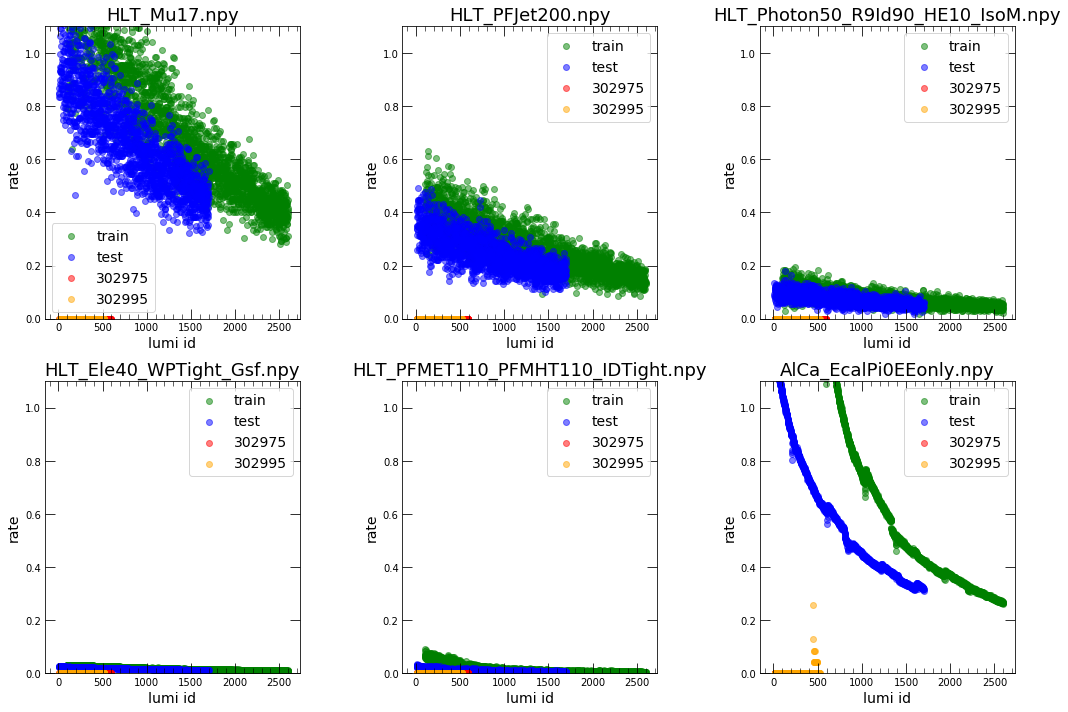

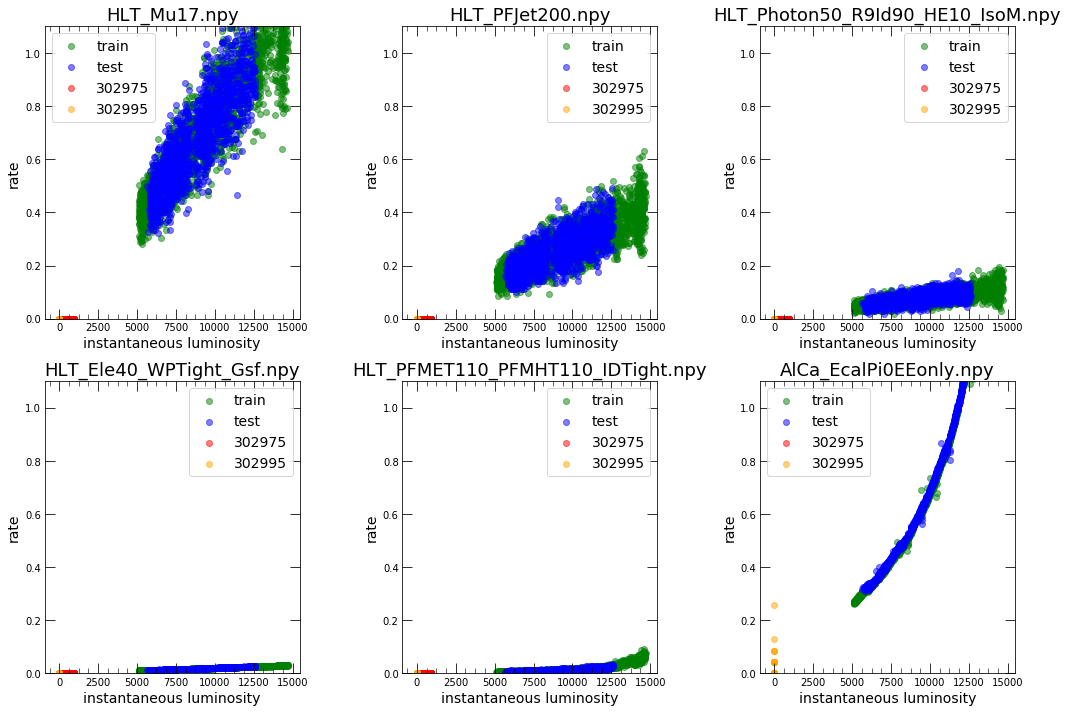

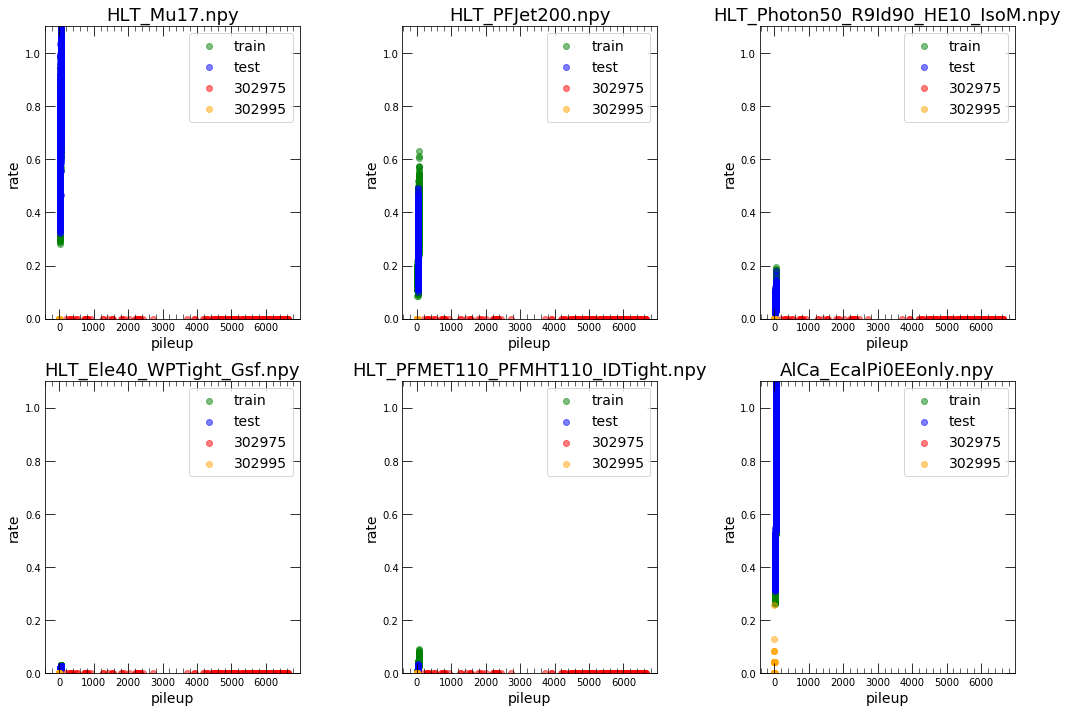

In [37]:
relativeerror = r"$\frac{input rate - output rate}{|input rate| + |output rate|}$"
sumsquareddif = r"$\sum_{i} (input rate_i-output rate_i)^2$"

plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","302975","302995"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0:
        lumi[h] = good_data["304144"]['lumiid']
        inst[h] = good_data["304144"]['instlumi']
        pileup[h] = good_data["304144"]['pileup']
        stuff[h] = good_data["304144"]['rates']
    elif h == 1:
        lumi[h] = good_data["304125"]['lumiid']
        inst[h] = good_data["304125"]['instlumi']
        pileup[h] = good_data["304125"]['pileup']
        stuff[h] = good_data["304125"]['rates']
    elif h == 2:
        lumi[h] = bad_data["302975"]['lumiid']
        inst[h] = bad_data["302975"]['instlumi']
        pileup[h] = bad_data["302975"]['pileup']
        stuff[h] = bad_data["302975"]['rates']
    else:
        lumi[h] = bad_data["302995"]['lumiid']
        inst[h] = bad_data["302995"]['instlumi']
        pileup[h] = bad_data["302995"]['pileup']
        stuff[h] = bad_data["302995"]['rates']
    
labels = good_data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.ylim(0,1.1)
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()
    plt.ylim(0,1.1)

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()
    plt.ylim(0,1.1)


plt.tight_layout()

plt.show()

## Simple Autoencoder

In [52]:
model_name = "normedRateAvgByEra"

In [53]:
# Define the architecture

_input = Input(shape=(6,), name="input")

middle = Dense(5,
               #kernel_initializer=Ones(),
               #bias_initializer=Zeros(),
               #kernel_constraint=non_neg(),
               #bias_constraint=non_neg(),
               activation = 'relu',
               name="middle")(_input)

norm = BatchNormalization()(middle)

hidden = Dense(3,
               #kernel_initializer=Ones(),
               #bias_initializer=Zeros(),
               #kernel_constraint=non_neg(),
               #bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(norm)

p_layer = Input(shape=(1,), name="pileup")

concat = concatenate([p_layer,hidden])

normhidden = BatchNormalization()(concat)

middle2 = Dense(5,
               #kernel_initializer=Ones(),
               #bias_initializer=Zeros(),
               #kernel_constraint=non_neg(),
               #bias_constraint=non_neg(),
               activation = 'relu',
               name="middle2")(normhidden)

normmiddle = BatchNormalization()(middle2)

output = Dense(6,
               #kernel_initializer=Ones(),
               #bias_initializer=Zeros(),
               #kernel_constraint=non_neg(),
               #bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(normmiddle)

normout = BatchNormalization()(output)

model = Model([_input,p_layer], normout)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 6)            0                                            
__________________________________________________________________________________________________
middle (Dense)                  (None, 5)            35          input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 5)            20          middle[0][0]                     
__________________________________________________________________________________________________
pileup (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
encoded (D

Train on 2437 samples, validate on 1763 samples
Epoch 1/500
 - 6s - loss: 1.2611 - val_loss: 1.6527
Epoch 2/500
 - 0s - loss: 1.2266 - val_loss: 1.4068
Epoch 3/500
 - 0s - loss: 1.1876 - val_loss: 1.1144
Epoch 4/500
 - 0s - loss: 1.1483 - val_loss: 0.8946
Epoch 5/500
 - 0s - loss: 1.1088 - val_loss: 0.7216
Epoch 6/500
 - 0s - loss: 1.0694 - val_loss: 0.6019
Epoch 7/500
 - 0s - loss: 1.0308 - val_loss: 0.5184
Epoch 8/500
 - 0s - loss: 0.9933 - val_loss: 0.4682
Epoch 9/500
 - 0s - loss: 0.9586 - val_loss: 0.4203
Epoch 10/500
 - 0s - loss: 0.9261 - val_loss: 0.3808
Epoch 11/500
 - 0s - loss: 0.8964 - val_loss: 0.3461
Epoch 12/500
 - 0s - loss: 0.8686 - val_loss: 0.3232
Epoch 13/500
 - 0s - loss: 0.8433 - val_loss: 0.3104
Epoch 14/500
 - 0s - loss: 0.8190 - val_loss: 0.3058
Epoch 15/500
 - 0s - loss: 0.7964 - val_loss: 0.3084
Epoch 16/500
 - 0s - loss: 0.7747 - val_loss: 0.3176
Epoch 17/500
 - 0s - loss: 0.7540 - val_loss: 0.3292
Epoch 18/500
 - 0s - loss: 0.7339 - val_loss: 0.3425
Epoch 1

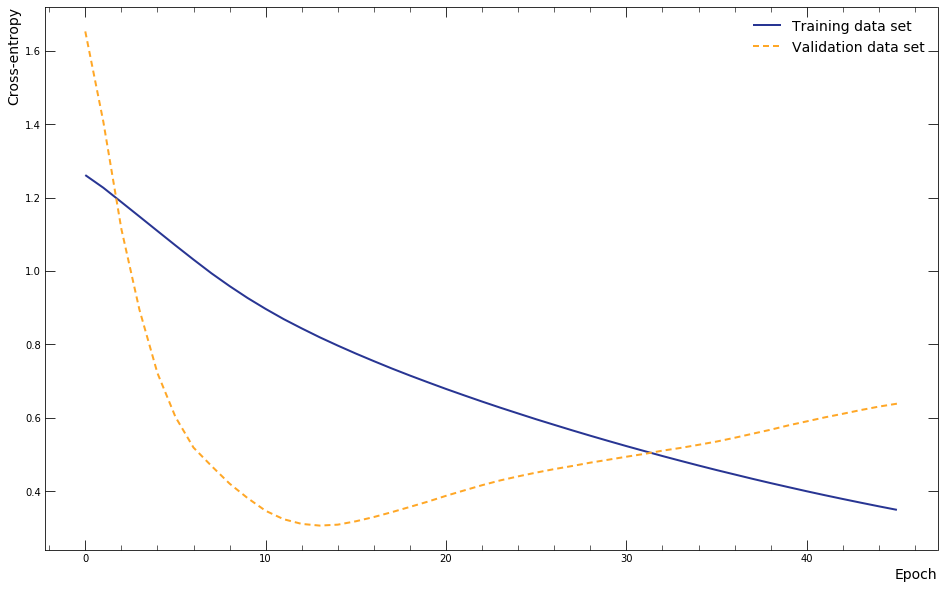

In [54]:
# Train neural networks
history = train_nn(model, x_train, pileup_train, 1024, "mse", model_name, x_val, pileup_val).history
plot_loss(history)

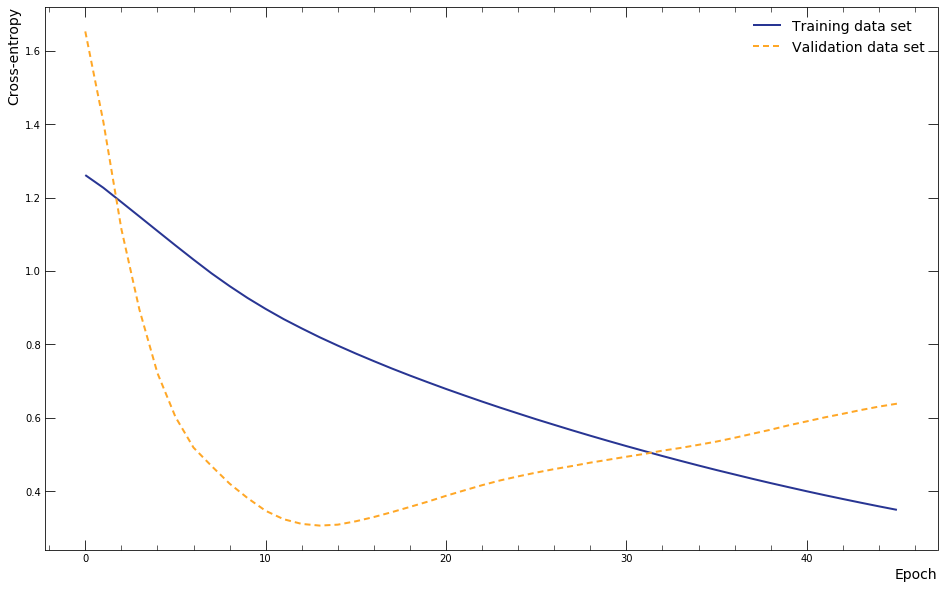

In [55]:
plot_loss(history)

In [56]:
model = load_model("%s.h5" % ("normedRateAvgByEra"))

In [57]:
for l in model.layers:
    print(l.name)
    print(l.weights)
    
model.get_weights()

input
[]
middle
[<tf.Variable 'middle_7/kernel:0' shape=(6, 5) dtype=float32_ref>, <tf.Variable 'middle_7/bias:0' shape=(5,) dtype=float32_ref>]
batch_normalization_9
[<tf.Variable 'batch_normalization_9_1/gamma:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'batch_normalization_9_1/beta:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'batch_normalization_9_1/moving_mean:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'batch_normalization_9_1/moving_variance:0' shape=(5,) dtype=float32_ref>]
pileup
[]
encoded
[<tf.Variable 'encoded_7/kernel:0' shape=(5, 3) dtype=float32_ref>, <tf.Variable 'encoded_7/bias:0' shape=(3,) dtype=float32_ref>]
concatenate_3
[]
batch_normalization_10
[<tf.Variable 'batch_normalization_10_1/gamma:0' shape=(4,) dtype=float32_ref>, <tf.Variable 'batch_normalization_10_1/beta:0' shape=(4,) dtype=float32_ref>, <tf.Variable 'batch_normalization_10_1/moving_mean:0' shape=(4,) dtype=float32_ref>, <tf.Variable 'batch_normalization_10_1/moving_variance:0' shape=(4,) dtyp

[array([[-0.3394774 , -0.6280245 ,  0.76309717,  0.32935956,  0.2142104 ],
        [ 0.4301216 , -0.24834456,  0.50582784, -0.5093106 ,  0.6560873 ],
        [-0.13648641, -0.6323346 ,  0.09552186, -0.2042498 ,  0.14069635],
        [ 0.18797171,  0.21918753,  0.07340969, -0.06093949,  0.00394355],
        [ 0.5346411 , -0.22881325, -0.11327848,  0.08392736,  0.14372063],
        [-0.57848334,  0.7034688 ,  0.28600687,  0.00402056, -0.46251023]],
       dtype=float32),
 array([ 0.        , -0.00871541, -0.01013538, -0.06876949,  0.10452162],
       dtype=float32),
 array([1.        , 0.975194  , 0.87519735, 0.9486343 , 1.1262051 ],
       dtype=float32),
 array([ 0.03502415,  0.04633944,  0.03652444,  0.0094108 , -0.04162436],
       dtype=float32),
 array([0.        , 0.01335542, 0.81625414, 0.00398194, 0.23603444],
       dtype=float32),
 array([0.        , 0.00228668, 0.00945567, 0.00020475, 0.0107161 ],
       dtype=float32),
 array([[ 0.7200461 , -0.6807553 ,  0.02280414],
       

## Training Set

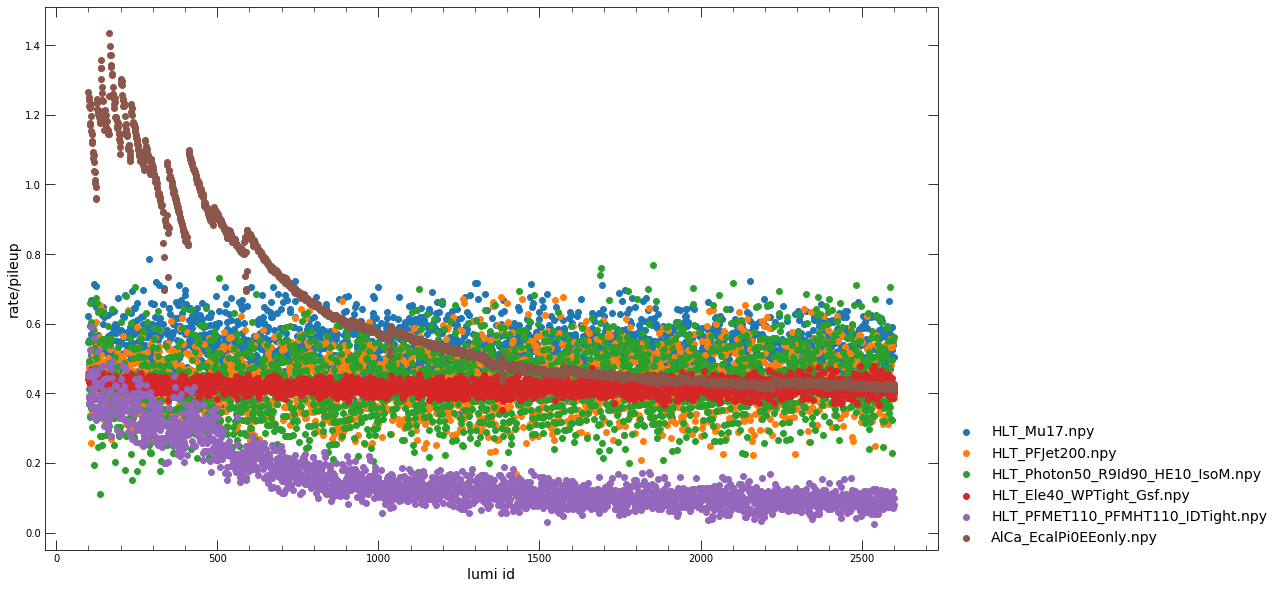

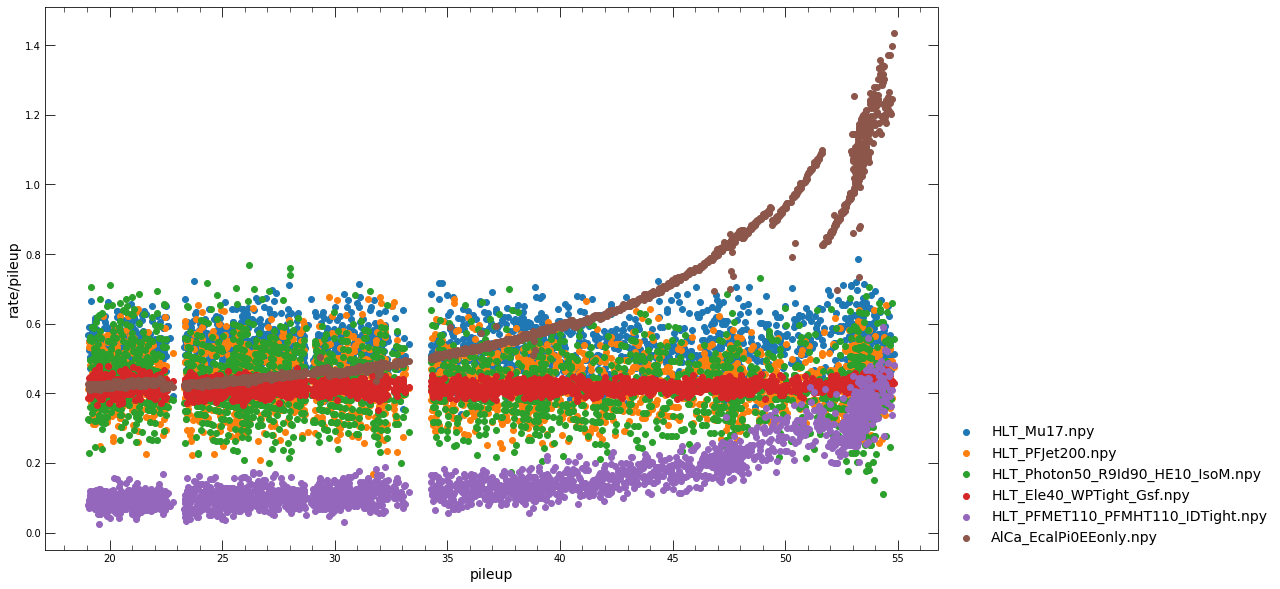

In [58]:
samples = good_data[runs_by_era[m][n]]['samples']
lumi_train = good_data[runs_by_era[m][n]]['lumiid']
pileup_train = good_data[runs_by_era[m][n]]['pileup'][0]
inputs = []
for s in range(len(samples)):
    for r in range(len(samples[s])):
        if s == 0:
            inputs.append([])
        inputs[r].append(samples[s][r])
            
plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(lumi_train,inputs[r],label=labels[r])
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.xlabel('lumi id')
plt.ylabel('rate/pileup')

plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(pileup_train,inputs[r],label=labels[r])
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.xlabel('pileup')
plt.ylabel('rate/pileup')
plt.show()

In [59]:
# Generate predictions

model = load_model("%s.h5" % (model_name))
    
reconstructed_train = model.predict([np.array(x_train),pileup_train])

error = (x_train-reconstructed_train)/(abs(x_train)+abs(reconstructed_train))

In [60]:
error_train_reformat = []
max_error_train = []
inp = []
outp = []
for i in range(num_rates):
    error_train_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    max_error_train.append(max(error[i]))
    for j in range(num_rates):
        error_train_reformat[j].append(error[i][j])
        outp[j].append(reconstructed_train[i][j])
        inp[j].append(x_train[i][j])

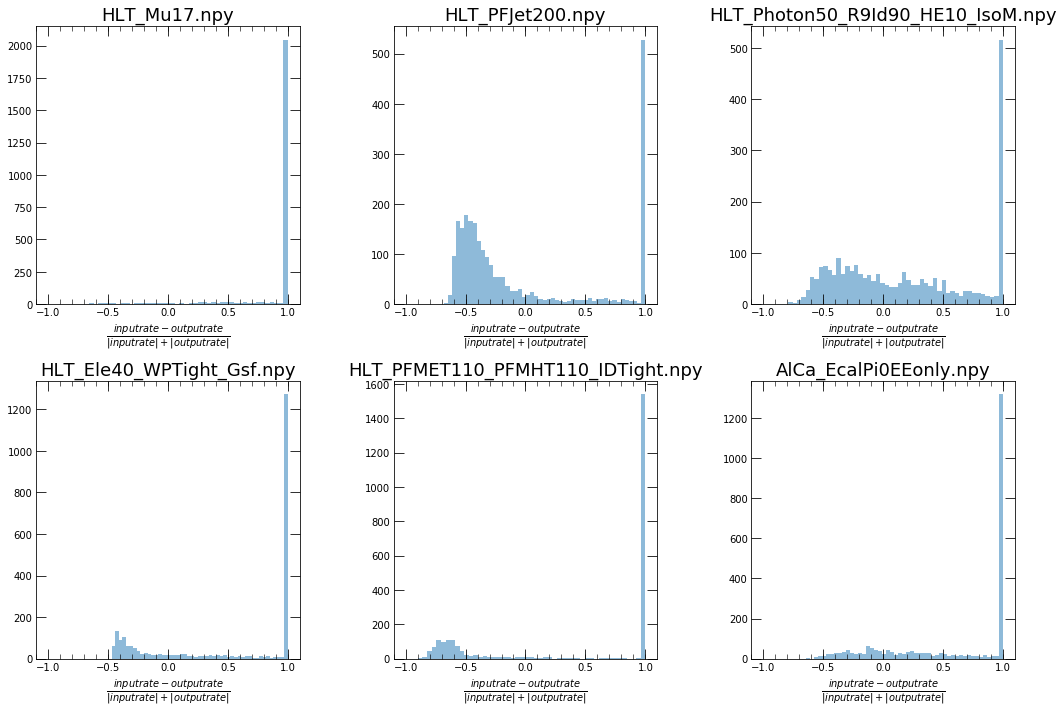

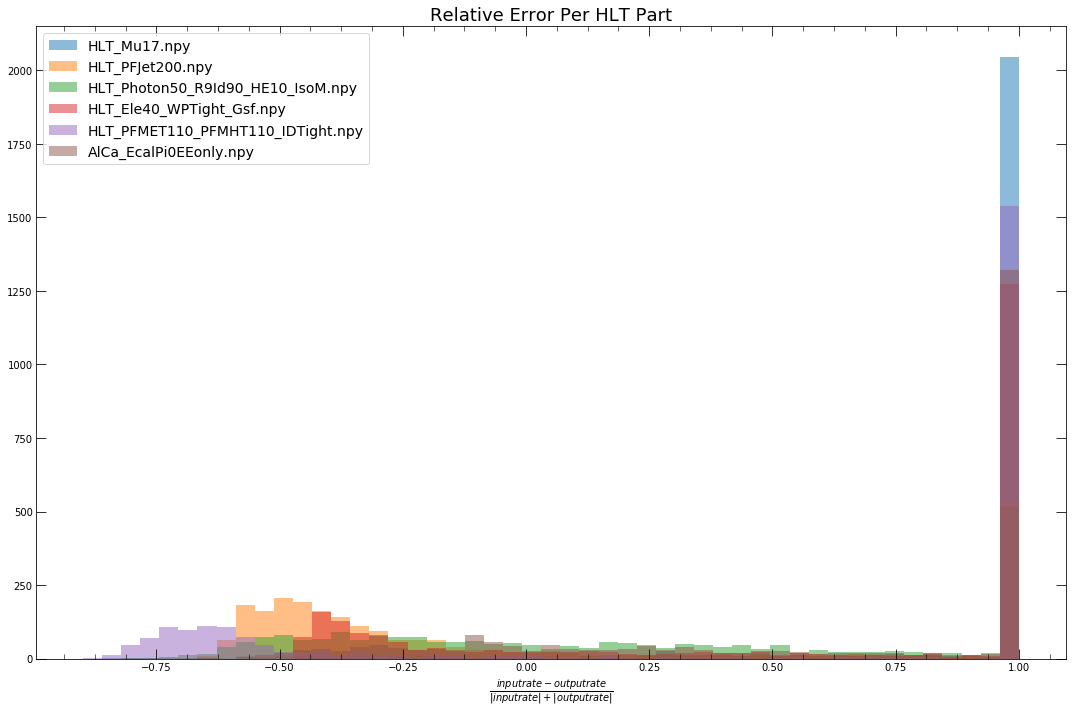

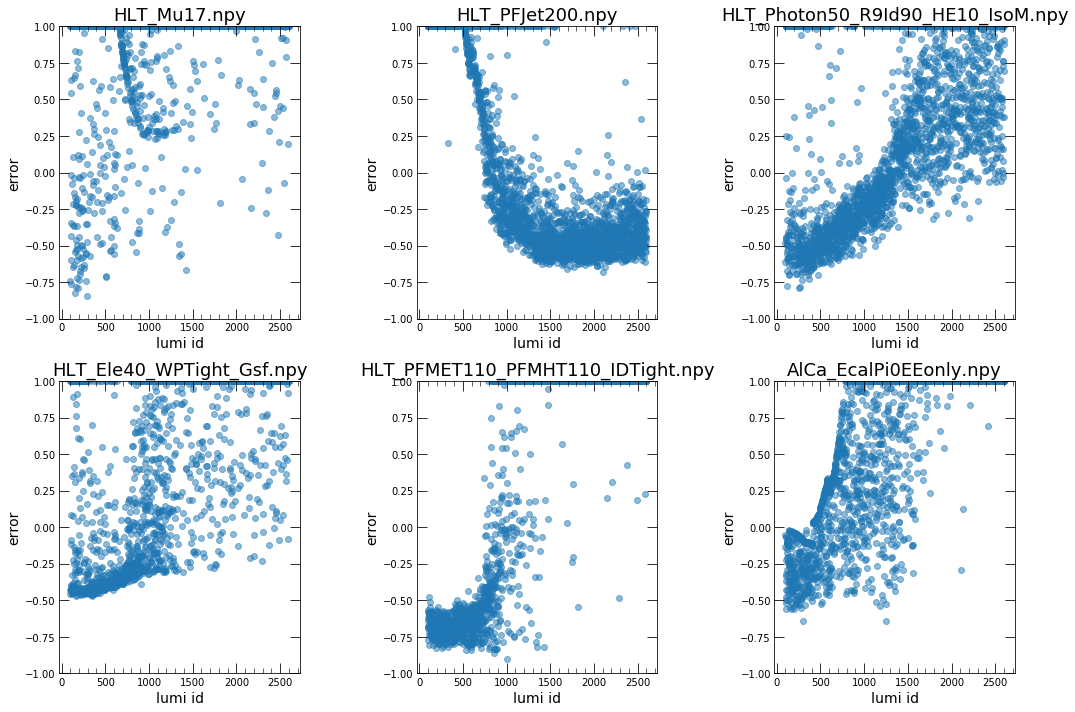

In [61]:
#bins = np.linspace(0,1,50)

plt.figure(figsize=[15,10])
for i in range(len(error_train_reformat)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(error_train_reformat[i]),max(error_train_reformat[i]),50)
    plt.hist(error_train_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.title(labels[i])
    plt.xlim(-1.1,1.1)
    plt.xlabel(relativeerror)
plt.tight_layout()

plt.figure(figsize=[15,10])
mins = []
maxes = []
for err in error_train_reformat:
    mins.append(min(err))
    maxes.append(max(err))
bins = np.linspace(min(mins),max(maxes),50)
for i in range(len(error_train_reformat)):
    plt.hist(error_train_reformat[i],bins=bins,label=labels[i],alpha=.5)
plt.title('Relative Error Per HLT Part')
plt.xlabel(relativeerror)
plt.legend()
plt.tight_layout()

#lumi_train = np.linspace(0,len(error_train_reformat0]),len(error_train_reformat0]))
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_train,error_train_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])  
    plt.ylim(-1,1)
plt.tight_layout()


plt.show()

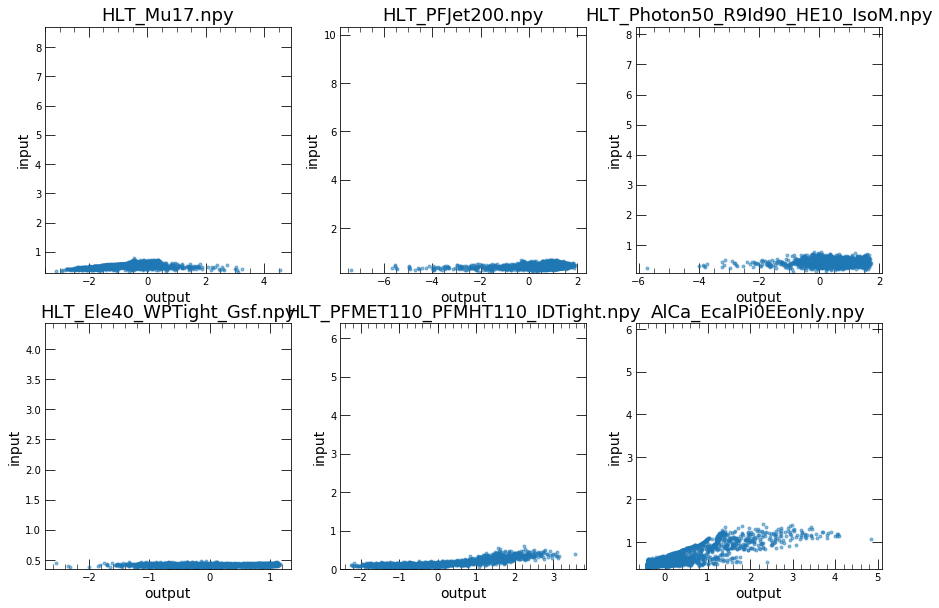

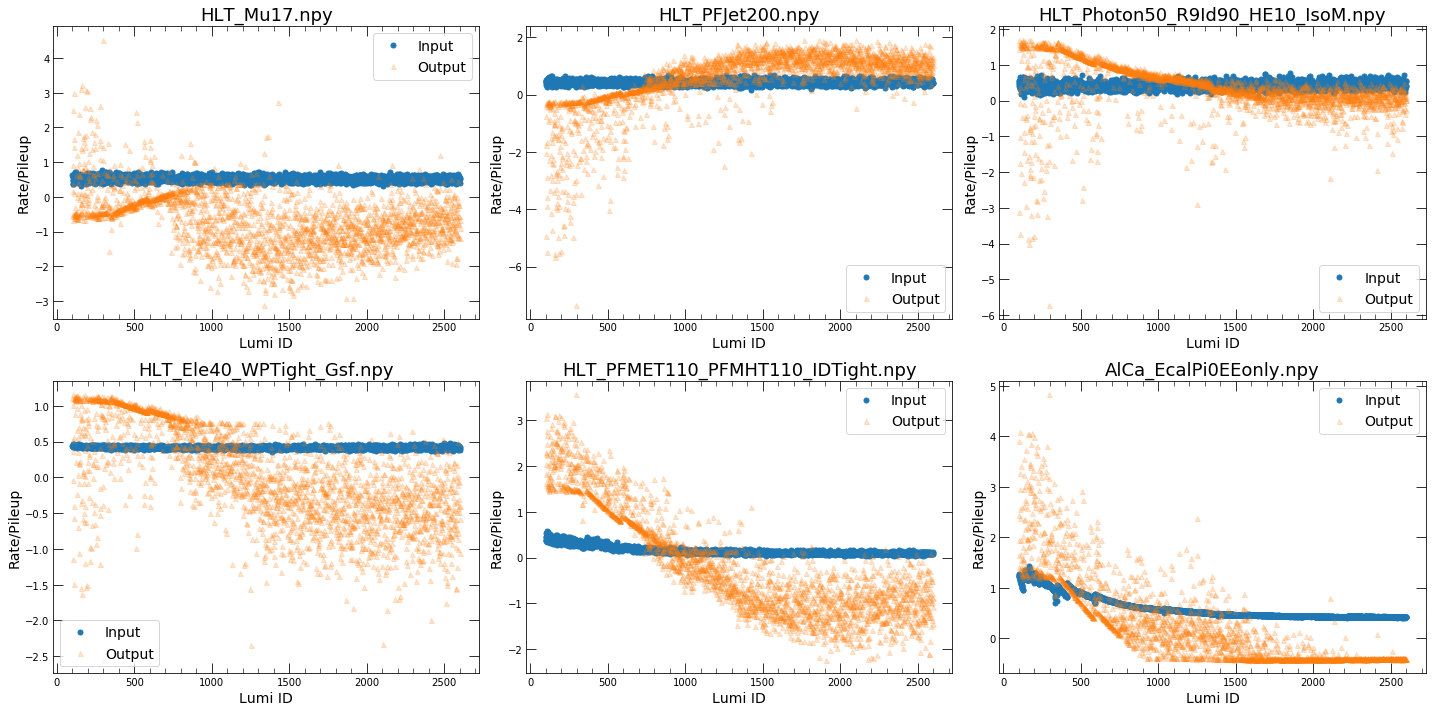

In [66]:
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi_train,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.title(labels[i])
    plt.axis('square')
    #plt.xlim(0,5)
    #plt.ylim(0,5)
    
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(lumi_train,inp[i],label='Input', linestyle='',marker='o', markersize=5)
    plt.plot(lumi_train,outp[i],label='Output', linestyle='',marker='^',markersize=5,alpha=.2)
    plt.title(labels[i])
    plt.xlabel('Lumi ID')
    plt.ylabel('Rate/Pileup')
    #plt.xlim(0,.5)
    #plt.ylim(0,5)
    plt.legend()    
plt.tight_layout()
    

plt.tight_layout()
plt.show()

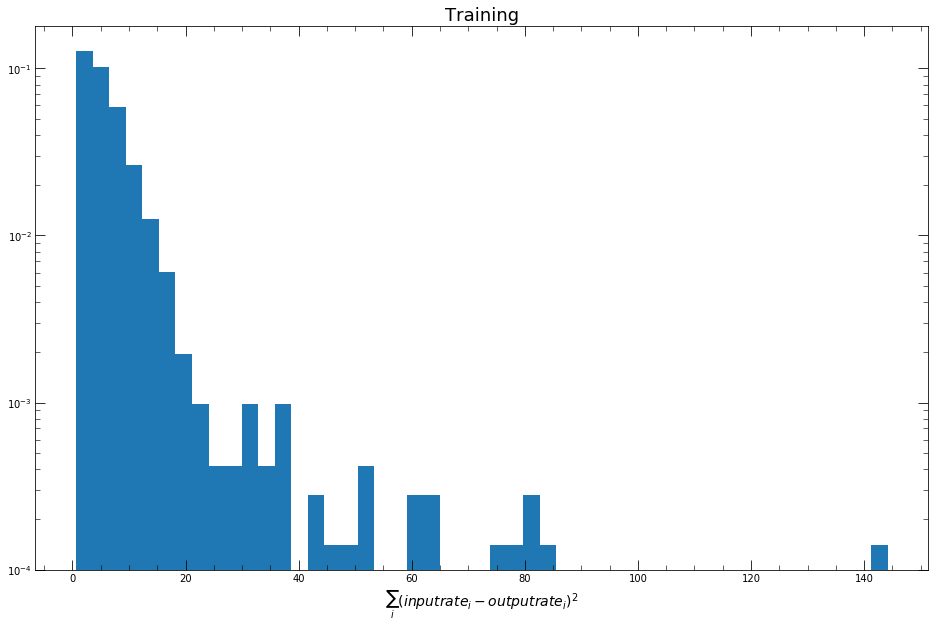

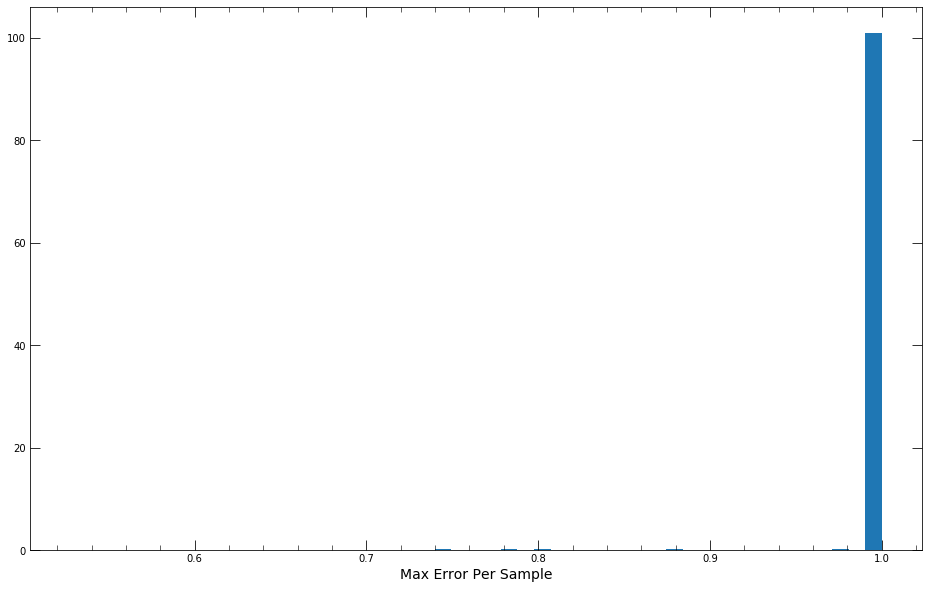

In [63]:
error_train = []
for r in range(len(reconstructed_train)):
    temp = 0
    for s in range(len(reconstructed_train[r])):
        temp+=(reconstructed_train[r][s]-x_train[r][s])**2
    error_train.append(temp)

bins = np.linspace(min(error_train),max(error_train),50)
plt.figure()
plt.hist(error_train,bins=bins,density=True)
plt.xlabel(sumsquareddif)
plt.title('Training')
plt.yscale('log')

plt.figure()
bins = np.linspace(min(max_error_train),max(max_error_train),50)
plt.hist(max_error_train,bins=bins,density=True,label='Training')
plt.xlabel('Max Error Per Sample')

plt.show()

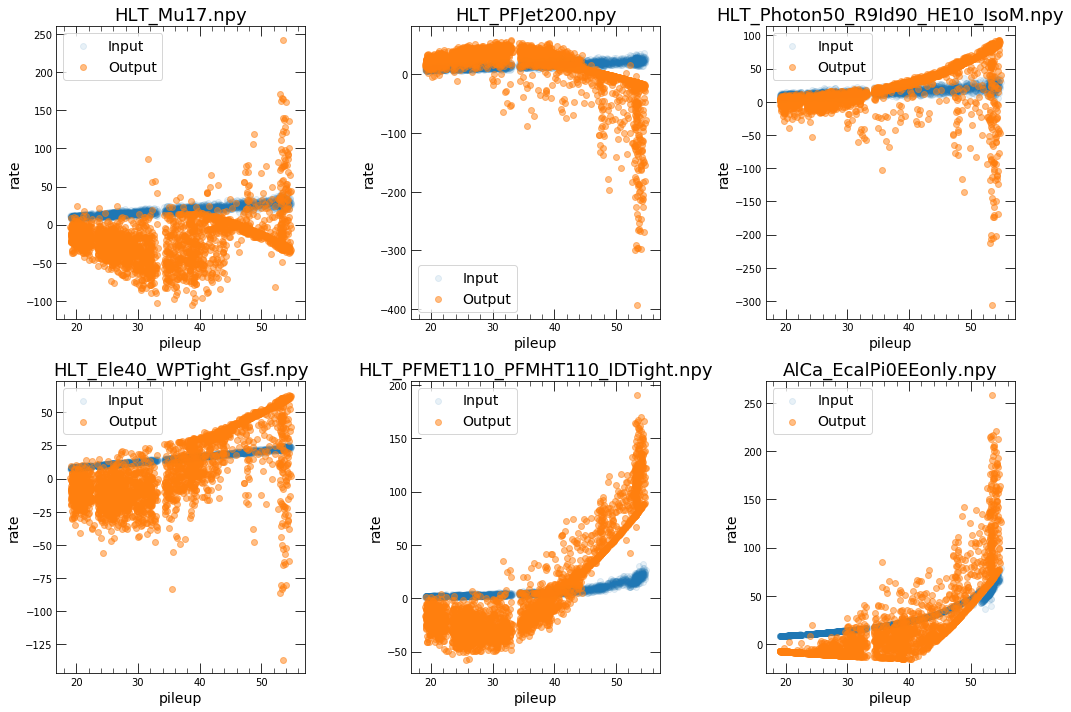

In [64]:
output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_train)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_train[r][o]*pileup_train[r])
        input_rates[o].append(x_train[r][o]*pileup_train[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_train,input_rates[i],label='Input',alpha=.1)
    plt.scatter(pileup_train,output_rates[i],label='Output',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()
    #plt.ylim(0,45)

plt.tight_layout()

plt.show()

In [65]:
print(reconstructed_train[0])

[-0.5544658  -0.32281083  1.581842    1.1153024   1.6315182   1.4189014 ]
